In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import scipy
from imageio import imread
from itertools import compress
import skimage.io as io
import skimage.transform as trans
from skimage import util 
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import *
np.set_printoptions(threshold=np.inf)
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

2.3.1


In [2]:
from platform import python_version

print(python_version())

3.7.4


In [5]:
train_images_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Data/Images/Train/'
train_masks_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Data/Masks/Train/'

test_images_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Data/Images/Test/'
test_masks_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Data/Masks/Test/'
# Modify before running
shared_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Results/Images'
results_path = shared_path+'/' 
#os.mkdir(results_path+'Images')
images_path = results_path+'Images/' #change kernel size number
model_name = 'Dual_Input_Unet_Model.h5 '




In [6]:
def filename_grabber(image_path = None, extensions = ['bmp']):
    """
   Grabs files names from directory and returns a list of their names
    
    Parameters
    ----------
    image_path : string
        Full file path that leads to image directory
        
    extensions : list of strings
        string of file extensions, without a period, within a list

    Returns
    -------
    file_names_images : list
        List of all specified files with predefined extensions 
        
    Notes
    -----
    """
    file_names_images = [fn for fn in os.listdir(image_path)
        if any(fn.endswith(ext) for ext in extensions)]
    file_names_images.sort()
    return file_names_images




In [7]:
# CANNY IMAGE NAAMES & MASKS
included_extensions = ['bmp']
train_images_names = filename_grabber(train_images_path)
train_masks_names = filename_grabber(train_masks_path)


test_images_names = filename_grabber(test_images_path)
test_masks_names = filename_grabber(test_masks_path)

In [6]:
# print(len(file_names_images))
print(len(train_images_names))
print(len(train_masks_names))

print(len(test_images_names))
print(len(test_masks_names))

1040
1040
80
80


Preallocate Image Matrices, Read & Crop them

In [8]:
size = 160

train_images = np.zeros((len(train_images_names),160,size, 1)).astype('float')
Nimages = np.zeros((len(train_images_names),160,size, 1)).astype('float')

for i in range(len(train_images_names)):
    train_image = imread(train_images_path+train_images_names[i], as_gray=True)/255


    train_image = train_image[..., None] # adds a channel layer
    train_images[i] = train_image[1:,:-1] # adds subsequent image arrays to img matrix
    
print(train_images.shape)


(1040, 160, 160, 1)


In [9]:
size = 160

test_images = np.zeros((len(test_images_names),160,size, 1)).astype('float')
Nimages = np.zeros((len(test_images_names),160,size, 1)).astype('float')

for i in range(len(test_images_names)):
    test_image = imread(test_images_path+test_images_names[i], as_gray=True)/255


    test_image = test_image[..., None] # adds a channel layer
    test_images[i] = test_image[1:,:-1] # adds subsequent image arrays to img matrix
    
print(test_images.shape)

(80, 160, 160, 1)


In [10]:
# GRAB ALL MASK IMAGES & CROP
train_masks = np.zeros((len(train_images_names), 160, size, 1)).astype('float')
for i in range(len(train_images_names)):
    train_mask = imread(train_masks_path+train_masks_names[i], as_gray=True)/255
    minimum = train_masks.min()
    train_mask = np.where(train_mask==minimum, 0, 1)
    train_mask = train_mask[..., None]
    train_masks[i] = train_mask[1:,:-1] # adds subsequent image arrays to img matrix


print(train_masks.shape)

(1040, 160, 160, 1)


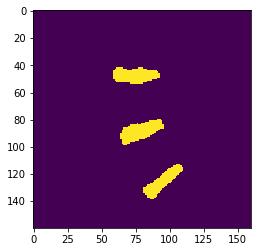

In [10]:
plt.imshow(np.sum(train_images[100],axis=2))
plt.imshow(np.sum(train_masks[100],axis=2))

In [11]:
# GRAB ALL MASK IMAGES & CROP
test_masks = np.zeros((len(test_images_names), 160, size, 1)).astype('float')
for i in range(len(test_images_names)):
    test_mask = imread(test_masks_path+test_masks_names[i], as_gray=True)/255
    minimum = test_mask.min()
    test_mask = np.where(test_mask==minimum, 0, 1)
    test_mask = test_mask[..., None]
    test_masks[i] = test_mask[1:,:-1] # adds subsequent image arrays to img matrix


print(test_masks.shape)

(80, 160, 160, 1)


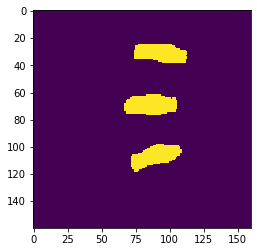

In [12]:
plt.imshow(np.sum(test_images[30],axis=2))
plt.imshow(np.sum(test_masks[30],axis=2))

In [12]:
def get_dataset(images, mask, batch_size, shuffle = True):
    a = np.shape(images)
    if a[0] ==2:
        im1 = images[0]
        im2 = images[1]
        dataset_input = tf.data.Dataset.from_tensor_slices(tf.constant(im1, dtype=tf.float32))
        dataset_input2 = tf.data.Dataset.from_tensor_slices(tf.constant(im2, dtype=tf.float32))
        dataset_mask = tf.data.Dataset.from_tensor_slices(tf.constant(mask, dtype=tf.float32))
        
        dataset = tf.data.Dataset.zip(((dataset_input,dataset_input2) , dataset_mask))
    else:    
        dataset_input = tf.data.Dataset.from_tensor_slices(tf.constant(images, dtype=tf.float32))
        dataset_mask = tf.data.Dataset.from_tensor_slices(tf.constant(mask, dtype=tf.float32))
        dataset_input = dataset_input.map(lambda x: tf.image.per_image_standardization(x))
        dataset_input = dataset_input.map(lambda x: tf.image.adjust_contrast(x,1.2))
        dataset = tf.data.Dataset.zip((dataset_input, dataset_mask))
    if shuffle == True:
        
        dataset = dataset.shuffle(len(images)).repeat() #randomly shuffles dataset and repeats the dataset
    else:
        dataset = dataset.repeat()
    
    dataset = dataset.batch(batch_size).prefetch(batch_size)

    print(dataset)
    return dataset


In [13]:
train_dataset = get_dataset(images = train_images, mask = train_masks,batch_size =  10, shuffle = True)
test_dataset = get_dataset(images = test_images, mask = test_masks,batch_size =  10, shuffle = False)

<PrefetchDataset shapes: ((None, 160, 160, 1), (None, 160, 160, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 160, 160, 1), (None, 160, 160, 1)), types: (tf.float32, tf.float32)>


In [14]:
IMG_HEIGHT = 160
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 1

In [15]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [16]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 160, 160, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 320         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 32) 128         conv2d[0][0]                     
_______________________________________________________________________________________

In [17]:
def unet(pretrained_weights = None, input_size = (160,160,1), df=8, kernel_size = 3): 
    
    """
    Initiliazed a Keras implementation of Unet as defined previously by Ronnenburger et al., 2015
    
    Parameters
    ----------
    pretrained_weights : hdf5
        Keras model file from pretrained Unet
        
    input_size : tuple
        A tuple specifying the input (image) size in form (rows,columns,channels)
        
    df : int
        # of filters to include in first convolutional layer. # expands by 2 for each conv. level
   
   kernel_size : int
        Specifies filter size. Kernels are square (nxn).
    Returns
    -------
    model : h5
        untrained Keras model structure
        
    Notes
    -----
    """
    inputs = Input(input_size)
    conv1 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(df*2*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(df*2*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(df*2*2*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(df*2*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(df*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(df, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [18]:
model = unet(df=8, input_size=(160, size, 1), kernel_size=5)
y = model.count_params()

In [19]:
batch_size = 4
batch_size_test = 1
steps_epoch = np.int16(np.ceil(len(train_images)/batch_size))
steps_val = np.int16(np.ceil(len(train_images)/batch_size_test))

In [45]:
history = model.fit( x = train_dataset ,validation_data=  test_dataset, validation_steps=steps_val, epochs=5, verbose=1,steps_per_epoch=steps_epoch)

Epoch 1/5
240/240 [==============================] - 439s 2s/step - loss: 0.1057 - accuracy: 0.9705 - val_loss: 0.0535 - val_accuracy: 0.9766
Epoch 2/5
240/240 [==============================] - 421s 2s/step - loss: 0.0238 - accuracy: 0.9899 - val_loss: 0.0344 - val_accuracy: 0.9887
Epoch 3/5
240/240 [==============================] - 424s 2s/step - loss: 0.0121 - accuracy: 0.9951 - val_loss: 0.0343 - val_accuracy: 0.9897
Epoch 4/5
240/240 [==============================] - 428s 2s/step - loss: 0.0085 - accuracy: 0.9965 - val_loss: 0.0370 - val_accuracy: 0.9900
Epoch 5/5
240/240 [==============================] - 421s 2s/step - loss: 0.0068 - accuracy: 0.9972 - val_loss: 0.0370 - val_accuracy: 0.9906


In [46]:
# save trained model
model.save('Unet_NoPL_weights_5epoch.hdf5')

In [20]:
# load trained model and verify
model.load_weights('Unet_NoPL_weights_5epoch.hdf5')
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 160, 160, 8)  208         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 160, 160, 8)  1608        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 80, 80, 8)    0           conv2d_20[0][0]                  
_______________________________________________________________________________________

In [21]:
# threshold images to consistent value of 0.5 (everything above becomes 1 for bone)
results = model.predict(test_dataset, verbose=0, steps=steps_val)
results_thresh = results
threshold_val = 0.5
threshold_indices_1 = results_thresh > threshold_val
threshold_indices_0 = results_thresh <= threshold_val
results_thresh[threshold_indices_1] = 1
results_thresh[threshold_indices_0] = 0

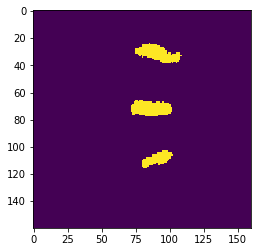

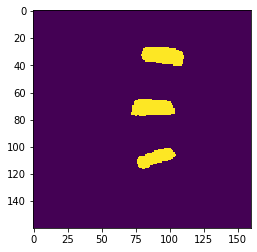

In [27]:
plt.imshow(np.sum(results[14],axis=2))
plt.figure()
plt.imshow(np.sum(test_masks[13],axis=2))

In [28]:
# export images
for i in range(len(test_images)):
    io.imsave(os.path.join(results_path,'Pred/', 
                           'predictedmask.'+str(i)+'.bmp'),results_thresh[i])
    io.imsave(os.path.join(results_path,'X/', 
                           'X_test.'+str(i)+'.bmp'),test_images[i])
    io.imsave(os.path.join(results_path,'Y/', 
                           'y_test.'+str(i)+'.bmp'),test_masks[i])

/Users/jacqueline/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Results/Images/Pred/predictedmask.0.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jacqueline/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Spine R01/AutoSegmentation/Results/Images/Y/y_test.0.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/jacqueline/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: 

In [22]:
def plot_examples(batch):
    plt.figure(figsize=(15, 15))
    for i in range(len(batch)):
        plt.subplot(8, 8, i+1)
        plt.imshow(batch[i])
#         plt.colorbar()
#         plt.axis('off')
        plt.gray()
    plt.show()

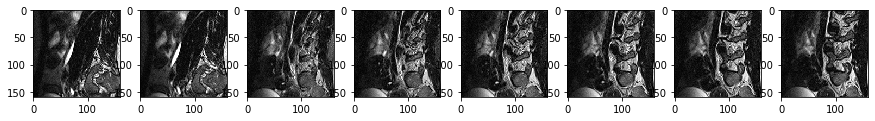

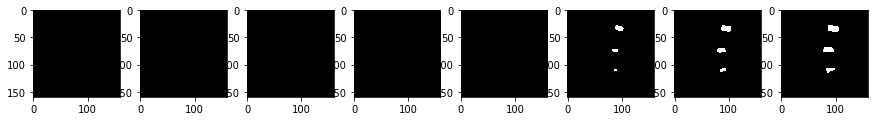

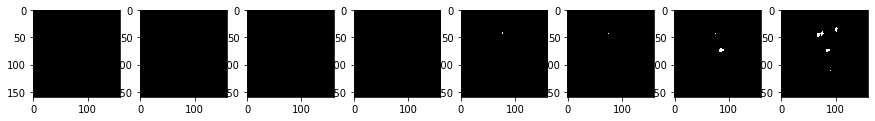

In [23]:
plot_examples(np.sum(test_images[0:8],axis=3)) # display the test images
plot_examples(np.sum(test_masks[0:8],axis=3)) # display the test masks
plot_examples(np.sum(results[0:8], axis=3)) # display thresholded images